# Copyright

<PRE>
Copyright (c) 2021 Bálint Gyires-Tóth - All Rights Reserved
You may use and modify this code for research and development purpuses.
Use this code for educational purposes (self-paced or instructor led) without the permission of the author is prohibited.
</PRE>

# Author classification
The task is to train a 1D CNN or an LSTM that is able to  classify text from two authors. The final model should be able to tell about a text with a given length (e.g. 60 characters) who wrote it. 

Please write the codes according to the following parts:

## Python module imports
Import all Python modules that you would need during the Assignment.

In [96]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import RMSprop
from urllib.request import urlretrieve
import numpy as np
import pandas as pd
import random
import sys
import re, cgi
import seaborn as sns

from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences


import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

## Data acquisition
Seek a possible dataset, you can use any source, e.g.
* http://www.gutenberg.org/
* https://www.kaggle.com/datasets
* https://paperswithcode.com/datasets
* if you would like to learn Hungarian, than e.g. https://mek.oszk.hu/

You can download the text by hand (e.g. by copy-pasting some parts into txt files) or with Python. 

In [82]:
# Shakespeare
url_book1= "https://www.gutenberg.org/files/1430/1430-0.txt"
urlretrieve(url_book1, 'book1.txt')
text1 = open("book1.txt", encoding='utf-8').read().lower()

# Mark Twain
url_book2= "https://www.gutenberg.org/files/76/76-0.txt"
urlretrieve(url_book2, 'book2.txt')
text2 = open("book2.txt", encoding='utf-8').read().lower()




In [83]:
# I split by text
split1=text1.split()
len(split1)

split2=text2.split()
len(split2)

114333

In [84]:
maxlen  = 40
step    = 5   
sentences1  = []
sentences2  = []

# the beginning and the ending are not related to their articles
for i in range(1000, len(split1)-maxlen-1000, step):
    sentences1.append(' '.join(split1[i:i+maxlen])) 


for i in range(1000, len(split2)-maxlen-1000, step):
    sentences2.append(' '.join(split2[i:i+maxlen])) 

In [85]:
# Create dataframe
df1 = pd.DataFrame(sentences1,columns =['Sentences'])
df1['Author_name'] = 'Shakespeare'
df1['Author'] = 0

df2 = pd.DataFrame(sentences2,columns =['Sentences'])
df2['Author_name'] = 'Mark Twain'
df2['Author'] = 1

In [86]:
# Combine two datasets into one
df = df1.append(df2)

In [87]:
df

,Sentences,Author_name,Author
0,"not properly be called any one of them, the na...",Shakespeare,0
1,"one of them, the nature of his occupation was ...",Shakespeare,0
2,of his occupation was such as to make it easy ...,Shakespeare,0
3,as to make it easy to understand how the vario...,Shakespeare,0
4,to understand how the various traditions spran...,Shakespeare,0
...,...,...,...
22454,you discover a defect in this electronic work ...,Mark Twain,1
22455,this electronic work within 90 days of receivi...,Mark Twain,1
22456,"days of receiving it, you can receive a refund...",Mark Twain,1
22457,can receive a refund of the money (if any) you...,Mark Twain,1


## Data analysis
Count the number of characters from both authors and display them on a plot (e.g. Seaborn's countplot).

In [88]:
words1 = sorted(list(set(split1)))
print('Number of unique words of the Shakespeare\'s book:', len(words1))

words2 = sorted(list(set(split2)))
print('Number of unique words of the Shakespeare\'s book:', len(words2))

Number of unique words of the Shakespeare's book: 9552
Number of unique words of the Shakespeare's book: 13510


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


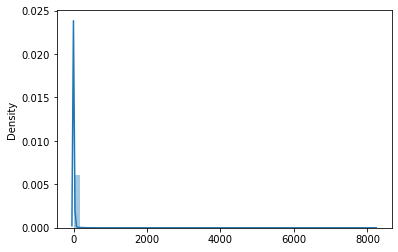

In [137]:
from nltk.probability import FreqDist
fdist = FreqDist(split1+split2)

values= list(fdist.values())
# values = [x for x in values if x>5]
sns.distplot(values) 

# From the plot we can tell setting MAX_NB_WORDS = 3000 in the tokenization part is a very safe choice.

## Data splitting
Split the data into train, validate and test sets.

In [89]:
# set aside 20% of train and test data for evaluation
X_train, X_test, y_train, y_test = train_test_split(df['Sentences'], df['Author'],
    test_size=0.2, shuffle = True, random_state = 8)

# Use the same function above for the validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
    test_size=0.25, random_state= 8) # 0.25 x 0.8 = 0.2

In [90]:
print("X_train shape: {}".format(X_train.shape))
print("X_test shape: {}".format(X_test.shape))
print("y_train shape: {}".format(y_train.shape))
print("y_test shape: {}".format(y_test.shape))
print("X_val shape: {}".format(X_val.shape))
print("y val shape: {}".format(y_val.shape))

X_train shape: (19542,)
X_test shape: (6514,)
y_train shape: (19542,)
y_test shape: (6514,)
X_val shape: (6514,)
y val shape: (6514,)


## Data loading, labeling and preprocessing
Load the data and convert the characters into one-hot encodings. Then load the data into a 3D NumPy array, with a shape of

* (batch, sequence_length, alphabet_length)

where sequence_length=60, and alphabet_length equals to the number of unique characters in both datasets. The sequences should be cut out from the complete dataset by sliding window. You should add 0 and 1 labels to the sequences, according to the author. 

Later you may change sequence_length to achieve better results!

In [91]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 3000
# Max number of words in each sentence.
MAX_SEQUENCE_LENGTH = 40
# This is fixed.
EMBEDDING_DIM = 20
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))



Found 10351 unique tokens.


In [92]:
X_train_seq = tokenizer.texts_to_sequences(X_train.values)
X_train_seq = pad_sequences(X_train_seq, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of training data tensor:', X_train_seq.shape)

X_val_seq = tokenizer.texts_to_sequences(X_val.values)
X_val_seq = pad_sequences(X_val_seq, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of validation data tensor:', X_val_seq.shape)

X_test_seq = tokenizer.texts_to_sequences(X_test.values)
X_test_seq = pad_sequences(X_test_seq, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of testing data tensor:', X_test_seq.shape)

Shape of training data tensor: (19542, 40)
Shape of validation data tensor: (6514, 40)
Shape of testing data tensor: (6514, 40)


## Model definition
Define a 1D CNN or an LSTM for the task. Compile the model with the correct loss function.

In [93]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, Conv1D, MaxPooling1D, Embedding,SpatialDropout1D, LSTM
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping


model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()



Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 40, 20)            60000     
                                                                 
 spatial_dropout1d_3 (Spatia  (None, 40, 20)           0         
 lDropout1D)                                                     
                                                                 
 lstm_3 (LSTM)               (None, 64)                21760     
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 81,825
Trainable params: 81,825
Non-trainable params: 0
_________________________________________________________________


## Model training
Train the model and apply early stopping.

In [94]:
epochs = 10
batch_size = 64

history = model.fit(X_train_seq, y_train, epochs=epochs, batch_size=batch_size,
                    validation_data=(X_val_seq,y_val),
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3)])


Epoch 1/10
306/306 [==============================] - 24s 67ms/step - loss: 0.1547 - accuracy: 0.9371 - val_loss: 0.0305 - val_accuracy: 0.9882
Epoch 2/10
306/306 [==============================] - 20s 66ms/step - loss: 0.0288 - accuracy: 0.9887 - val_loss: 0.0211 - val_accuracy: 0.9886
Epoch 3/10
306/306 [==============================] - 21s 67ms/step - loss: 0.0202 - accuracy: 0.9903 - val_loss: 0.0189 - val_accuracy: 0.9883
Epoch 4/10
306/306 [==============================] - 20s 66ms/step - loss: 0.0195 - accuracy: 0.9906 - val_loss: 0.0182 - val_accuracy: 0.9891
Epoch 5/10
306/306 [==============================] - 20s 67ms/step - loss: 0.0189 - accuracy: 0.9907 - val_loss: 0.0194 - val_accuracy: 0.9889
Epoch 6/10
306/306 [==============================] - 20s 67ms/step - loss: 0.0194 - accuracy: 0.9905 - val_loss: 0.0191 - val_accuracy: 0.9894
Epoch 7/10
306/306 [==============================] - 20s 66ms/step - loss: 0.0151 - accuracy: 0.9918 - val_loss: 0.0176 - val_accuracy:

## Evaluation on test data
Evaluate the model on the test data in terms of loss and accuracy.

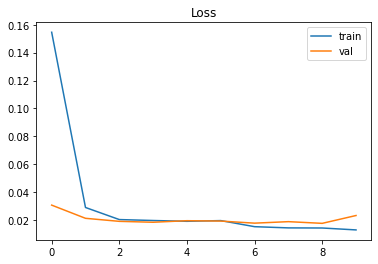

In [98]:
def plot_model_history(his):
  plt.title('Loss')
  plt.plot(his.history['loss'], label='train')
  plt.plot(his.history['val_loss'], label='val')
  plt.legend()
  plt.show();

plot_model_history(history)

In [99]:
print(model.evaluate(X_test_seq, y_test))


204/204 [==============================] - 3s 13ms/step - loss: 0.0218 - accuracy: 0.9880
[0.021841641515493393, 0.9880257844924927]


In [114]:
preds = model.predict(X_test_seq)

In [115]:
preds_label = [round(x[0]) for x in preds]

## Confusion matrix
Calculate and display the confusion matrix.

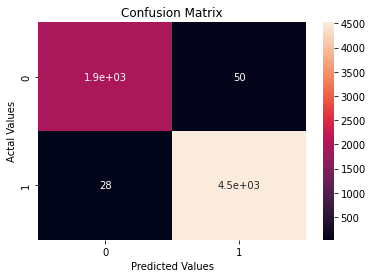

In [116]:
cm=confusion_matrix(y_test, preds_label)
plt.figure()
sns.heatmap(cm, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()